# Battery Flexible Dispatch for Electricity Arbitrage

## Problem Overview

In this analysis, we aim to explore optimal electricity arbitrage using batteries based on the Australian NEM (National Electricity Market) spot price data. The objective is to develop a model that can take advantage of fluctuations in electricity prices to maximise arbitrage opportunities by charging the battery when prices are low and discharging it when prices are high. The model is implemented as a Mixed-Integer Linear Programming (MILP) problem for brevity in this demo. This could be reframed as a RL Agentic model, or traditional ML model instead.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pulp

---
## Reading in the NEM Data and Initial Plotting

We first read in the NEM electricity spot price data, which is recorded at 5-minute intervals. This is a key aspect of the Australian NEM as the settlement period is 5 minutes. The initial plotting of the data shows its inherent volatility, which is typical of the spot market.

To make the modeling more efficient, we smooth the dataset by calculating the average spot price per hour. This aggregation helps in developing a more tractable optimisation model while retaining the general price trends for effective arbitrage modeling.

In [2]:
data = pd.read_csv(r"..\data\PRICE_AND_DEMAND_202409_QLD1.csv", date_format='%Y-%m-%d %H:%M:%S', parse_dates=['SETTLEMENTDATE'])
data.set_index('SETTLEMENTDATE', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2024-09-01 00:05:00 to 2024-09-06 00:00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   REGION       1440 non-null   object 
 1   TOTALDEMAND  1440 non-null   float64
 2   RRP          1440 non-null   float64
 3   PERIODTYPE   1440 non-null   object 
dtypes: float64(2), object(2)
memory usage: 56.2+ KB


In [3]:
data.head()

,REGION,TOTALDEMAND,RRP,PERIODTYPE
SETTLEMENTDATE,,,,
2024-09-01 00:05:00,QLD1,5753.36,96.75,TRADE
2024-09-01 00:10:00,QLD1,5772.24,96.75,TRADE
2024-09-01 00:15:00,QLD1,5734.08,96.75,TRADE
2024-09-01 00:20:00,QLD1,5690.55,77.95,TRADE
2024-09-01 00:25:00,QLD1,5653.29,77.75,TRADE


<Axes: title={'center': 'NEM Spot Price in Queensland'}, xlabel='SETTLEMENTDATE', ylabel='Price ($/MWh)'>

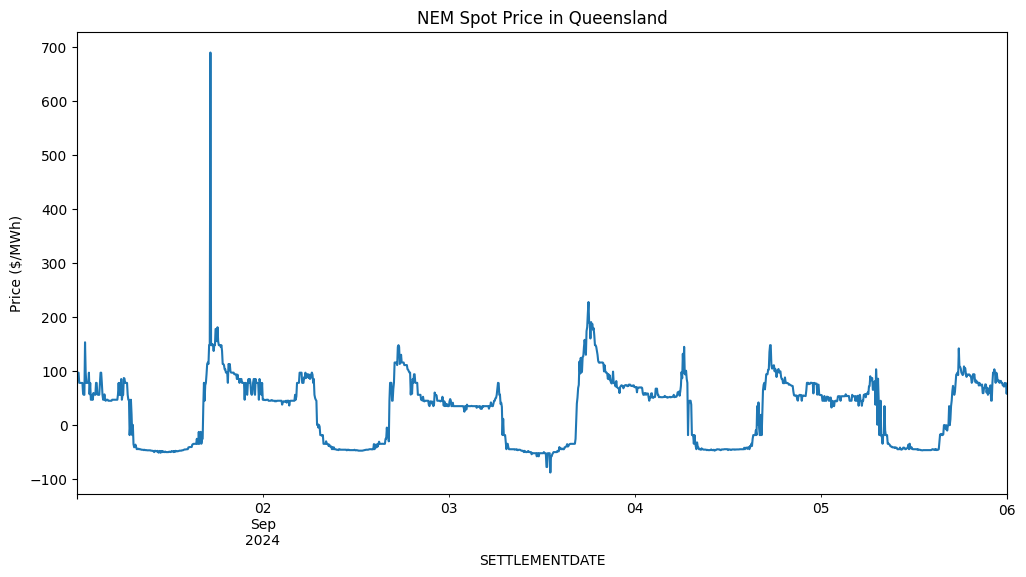

In [4]:
data.RRP.plot(figsize=(12, 6), title='NEM Spot Price in Queensland', ylabel='Price ($/MWh)')

In [5]:
hourly_data = data.groupby(data.index.strftime('%Y-%m-%d %H')).RRP.mean()
hourly_data.index = pd.to_datetime(hourly_data.index, format='%Y-%m-%d %H')

<Axes: title={'center': 'NEM Spot Price in Queensland'}, xlabel='SETTLEMENTDATE', ylabel='Price ($/MWh)'>

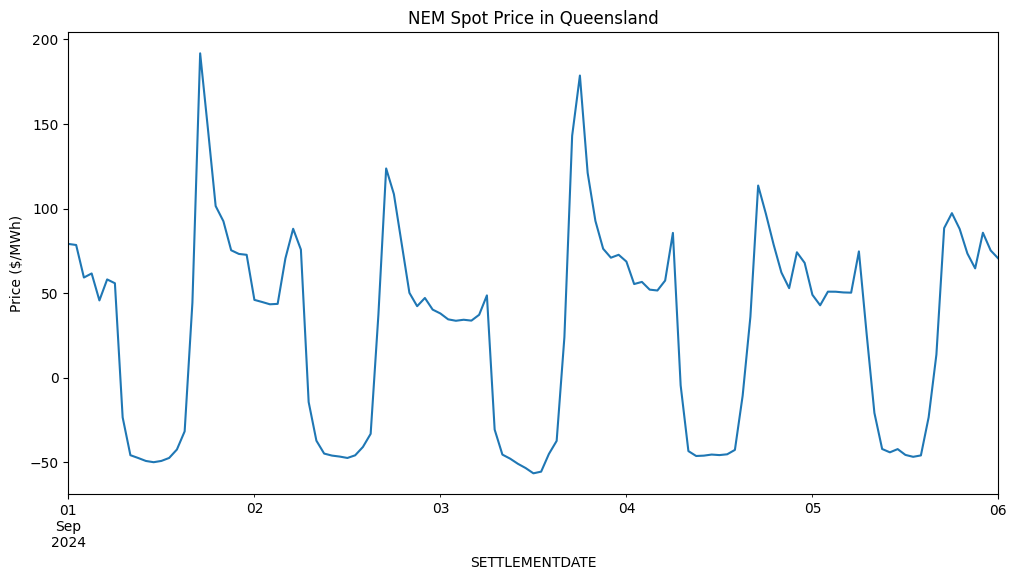

In [6]:
hourly_data.plot(figsize=(12, 6), title='NEM Spot Price in Queensland', ylabel='Price ($/MWh)')

---
## Building the Optimisation Model

We use the `PuLP` library to build the optimisation model. This model is formulated as a Mixed-Integer Linear Program (MILP), which aims to maximise profit by optimising the battery's charging and discharging activities based on the forecasted hourly spot prices.

### Key Model Components:
- **Objective Function**: Maximise the profit over the considered time range by optimising when to charge and discharge the battery.
- **Decision Variables**: 
  - Charge/discharge rates (MW)
  - State of charge (SOC, %)
  - Binary variables indicating whether the battery is charging or discharging
- **Constraints**:
  - Initial SOC value
  - Mutual exclusivity of charging and discharging
  - Charging and discharging rates limited by a maximum rate
  - The SOC in the current timestep must account for the previous SOC, adjusted by charge/discharge rates and efficiencies.
- **Limitations / Assumptions**:
  - We haven't considered battery degradation, dynamic charge/discharge rates, or any fixed/varibale costs including grid fees

### Key Equations:
#### Objective Function

The objective of the optimisation problem is to maximise profit, which is the revenue from discharging the battery minus the cost of charging it. The objective function is given by:

$$\max\left(\pi_{total}\right) = \max \left( \sum_{t=0}^{T-1} \left( \eta_d \cdot P_t \cdot d_t - \frac{P_t \cdot c_t}{\eta_c} \right) \right)$$

where:
- $P_t$ is the electricity price at time $t$,
- $d_t$ is the amount of discharge at time $t$,
- $c_t$ is the amount of charge at time $t$,
- $\eta_d$ and $\eta_c$ are the discharge and charge efficiencies, respectively.

#### Constraints

1. **State of Charge (SOC) Dynamics:**

The state of charge (SOC) of the battery evolves over time based on the previous SOC, the amount of charge, and the amount of discharge. The SOC constraint for each time step is:

$$E_t = E_{t-1} + \eta_c \cdot c_t - \frac{d_t}{\eta_d} \quad \forall t \geq 1$$

where:
- $E_t$ is the state of charge at time $t$,
- $E_{t-1}$ is the state of charge at the previous time step.

2. **Initial SOC Constraint:**

The initial SOC of the battery is given by:

$$
E_0 = E_{\text{initial}}
$$

where $E_{\text{initial}} $ is a predefined value.

3. **Mutual Exclusivity of Charging and Discharging:**

The battery cannot charge and discharge simultaneously. This is ensured with the following constraint:

$$
u_t + v_t \leq 1 \quad \forall t
$$

where:
- $u_t $ is a binary variable indicating charging ($u_t = 1 \)) or not ($u_t = 0 \)),
- $v_t $ is a binary variable indicating discharging ($v_t = 1 \)) or not ($v_t = 0 \)).

4. **Charging and Discharging Limits:**

The charging and discharging rates are constrained by a maximum power limit $P_{\text{max}}$. These constraints are expressed as:

$$
0 \leq c_t \leq P_{\text{max}} \cdot u_t \quad \forall t
$$
$$
0 \leq d_t \leq P_{\text{max}} \cdot v_t \quad \forall t
$$

where:
- $P_{\text{max}} $ is the maximum charging/discharging power.

5. **State of Charge Bound:**

The SOC at any time must not exceed the battery's maximum capacity $E_{\text{max}}$:

$$
0 \leq E_t \leq E_{\text{max}} \quad \forall t
$$

#### Solution Extraction

Once the problem is solved, the optimal values for charging $c_t$, discharging $d_t$, and the state of charge $E_t $ at each time step $t $ can be extracted.

The total profit can be calculated as:

$$
\pi_{\text{total}} = \sum_{t=0}^{T-1} \left( \eta_d \cdot P_t \cdot d_t - \frac{P_t \cdot c_t}{\eta_c} \right)
$$


In [7]:
def optimal_battery_schedule_pulp(prices, eta_c, eta_d, E_max, P_max, E_0):
    T = len(prices)  # Number of time steps

    # Create a problem variable
    prob = pulp.LpProblem("Optimal_Battery_Schedule", pulp.LpMaximize)

    # Decision variables:
    c = pulp.LpVariable.dicts("charge", range(T), lowBound=0, upBound=P_max, cat=pulp.LpContinuous)
    d = pulp.LpVariable.dicts("discharge", range(T), lowBound=0, upBound=P_max, cat=pulp.LpContinuous)
    E = pulp.LpVariable.dicts("SOC", range(T), lowBound=0, upBound=E_max, cat=pulp.LpContinuous)
    u = pulp.LpVariable.dicts("charge_indicator", range(T), lowBound=0, upBound=1, cat=pulp.LpBinary)
    v = pulp.LpVariable.dicts("discharge_indicator", range(T), lowBound=0, upBound=1, cat=pulp.LpBinary)

    # Objective: Maximise profit (revenue from discharge minus cost of charging)
    prob += pulp.lpSum([prices[t] * d[t] * eta_d - prices[t] * c[t] / eta_c for t in range(T)])

    # Constraints:
    
    # SOC dynamics: E_t = E_(t-1) + c_t*eta_c - d_t*(1/eta_d)
    for t in range(1, T):
        prob += E[t] == E[t-1] + c[t] * eta_c - d[t] * (1 / eta_d)

    # Initial SOC constraint: E_1 = E_0
    prob += E[0] == E_0

    # Mutual exclusivity of charging and discharging: u_t + v_t <= 1
    for t in range(T):
        prob += u[t] + v[t] <= 1

    # Charging and discharging power limits: 0 <= c_t <= P_max*u_t, 0 <= d_t <= P_max*v_t
    for t in range(T):
        prob += c[t] <= P_max * u[t]
        prob += d[t] <= P_max * v[t]

    # Solve the problem
    prob.solve()

    # Check if the optimisation was successful
    if pulp.LpStatus[prob.status] == 'Optimal':
        # Extract the results
        charging = [pulp.value(c[t]) for t in range(T)]
        discharging = [pulp.value(d[t]) for t in range(T)]
        soc = [pulp.value(E[t]) for t in range(T)]
        cashflow = [prices[t] * discharging[t] * eta_d - prices[t] * charging[t] / eta_c for t in range(T)]
        objective = pulp.value(prob.objective)
        return charging, discharging, soc, cashflow, objective
    else:
        raise ValueError("Optimisation failed")


---
## Running the Model over a 6-Day Period

The model is applied over a 6-day period, where we treat the smoothed hourly spot-price data as a forecast. The model takes advantage of significant price fluctuations, such as the increase in solar generation during the day and the price drop during nighttime hours.

### Observations:
- The model effectively captures price changes, especially during midday solar production and nighttime demand troughs.
- Several limitations exist, including:
  - No penalties for degradation or dynamic charging rates which would lead the model to be charging/discharge less frequently
  - Lack of real-world price volatility due to the smoothed price data
  - The use of actual data for "forecasting," which is simply a placeholder and should be replaced by a proper forecasting model.

The results show that while the battery optimisation strategy performs well under these conditions, further enhancements are needed to account for real-world complexities.

In [8]:
prices = hourly_data
eta_c = 0.95  # Charging efficiency
eta_d = 0.95  # Discharging efficiency
E_max = 100  # Maximum capacity (MWh)
P_max = 20  # Maximum charging/discharging power (MW)
E_0 = 0  # Initial state of charge (MWh)

charging, discharging, soc, cashflow, objective = optimal_battery_schedule_pulp(prices, eta_c, eta_d, E_max, P_max, E_0)

print(f"${objective:,.2f}")


C:\Users\Jack.Sweep2\AppData\Local\Temp\ipykernel_54028\1077081446.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prob += pulp.lpSum([prices[t] * d[t] * eta_d - prices[t] * c[t] / eta_c for t in range(T)])


$76,075.03


C:\Users\Jack.Sweep2\AppData\Local\Temp\ipykernel_54028\1077081446.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cashflow = [prices[t] * discharging[t] * eta_d - prices[t] * charging[t] / eta_c for t in range(T)]


In [9]:
output = pd.DataFrame({'Charge (MW)': charging, 'Discharge (MW)': discharging, 'SOC (MWh)': soc, 'Cashflow ($)': cashflow, 'Price ($/MWh)': prices.values}, index=prices.index)

In [10]:
real_cashflow = []
for t, price in data.RRP.items():
    hourly_index = t.replace(minute=0, second=0)
    discharge_val, charge_val = output.loc[hourly_index, "Discharge (MW)"], output.loc[hourly_index, "Charge (MW)"]
    real_cashflow.append((5/60)*(price * discharge_val * eta_d - price * charge_val / eta_c)) # adjusted for 5 minute intervals

Modelled Profit: $76,075.03
Real Profit: $75,949.80


Text(0, 0.5, 'Real Cashflow ($)')

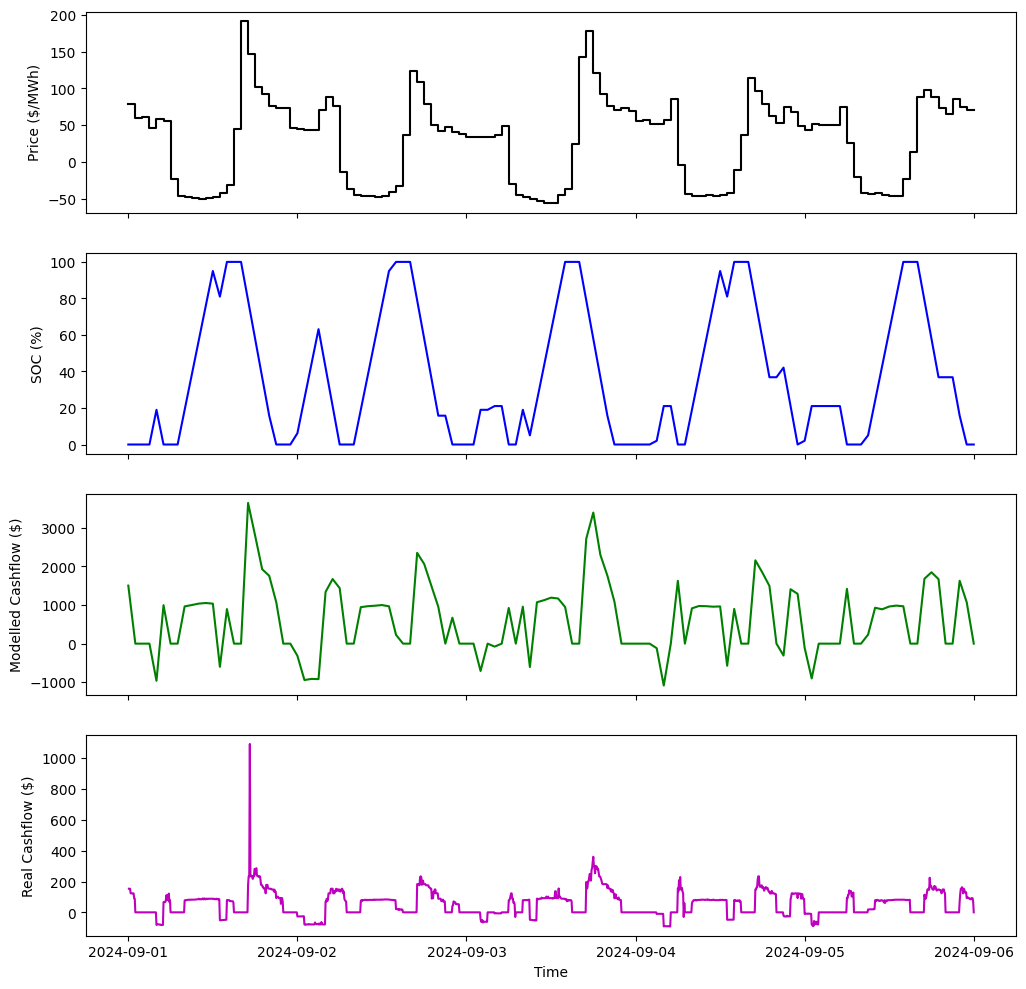

In [11]:
print(f"Modelled Profit: ${objective:,.2f}")
print(f"Real Profit: ${sum(real_cashflow):,.2f}")
fig, ax = plt.subplots(figsize=(12, 12), nrows=4, sharex=True)
_ = ax[0].step(prices.index, prices.values, '-k', label='Price')
_ = ax[1].plot(prices.index, soc, '-b', label='SOC')
_ = ax[2].plot(prices.index, cashflow, '-g', label='Cashflow ($)')
_ = ax[3].plot(data.index, real_cashflow, '-m', label='Real Cashflow ($)')
ax[3].set_xlabel('Time')
ax[0].set_ylabel('Price ($/MWh)')
ax[1].set_ylabel('SOC (%)')
ax[2].set_ylabel('Modelled Cashflow ($)')
ax[3].set_ylabel('Real Cashflow ($)')